In [1]:
import pandas as pd
from skbio.diversity import alpha_diversity

# Statistical tests
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import friedmanchisquare
from statsmodels.stats.multitest import multipletests
import itertools
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import_str = "/ceph/projects/179_Oncdon/shawn.loo/workspace/"

In [3]:
V107_data = pd.read_csv(f"{import_str}V107_maindataset.csv")
E975_data = pd.read_csv(f"{import_str}E975_maindataset.csv")

In [4]:
V107_data['pt_identifier'].unique()

array(['MAID-0728', 'MAID-0002', 'MAID-0732', '1010945946', 'MAID-0560',
       'MAID-0574', 'MAID-0231', 'MAID-0553', 'MAID-0018', 'MAID-0014',
       'MAID-0024', 'MAID-1028', 'MAID-0731', 'MAID-0727', 'MAID-0031',
       'MAID-1144', 'MAID-1187', 'MAID-1186', 'MAID-1162', '1009023135',
       'MAID-1101.1', 'MAID-1101.2'], dtype=object)

## Alpha Diversity

In [5]:
# Prepare table into OTU format
def create_OTU(df):

    result_tbl = df.pivot_table(
        index = "sample_id",
        columns = "genus",
        values = "abundance",
        aggfunc = "sum",
        fill_value = 0
    )
    
    return result_tbl

# Creating OTU table
V107_otu = create_OTU(V107_data)
E975_otu = create_OTU(E975_data)

# Building metadata for plotting
def create_metadata(df):
    
    metadata = df.drop_duplicates(subset = ["sample_id"])
    metadata = metadata[["sample_id", "group", "week", "pt_identifier"]]
    metadata.set_index("sample_id", inplace = True)
    
    return metadata

# Create metadata
V107_metadata = create_metadata(V107_data)
E975_metadata = create_metadata(E975_data)

In [6]:
# Saving OTU table for R
V107_otu.to_csv("V107_otu.csv")
E975_otu.to_csv("E975_otu.csv")

In [7]:
# Run alpha diversity tests
def run_alpha_div_test(df):
        
    alpha_test_metrics = ["shannon", "simpson", "chao1"]

    result_df = {}
    
    for tests in alpha_test_metrics:
        
        result_df[tests] = alpha_diversity(tests, df.values, ids = df.index)
        
    # Converting raw simpson score
    result_df["simpson"] = 1 - result_df["simpson"]
            
    return pd.DataFrame(result_df, index = df.index)

V107_alpha_div_df = run_alpha_div_test(V107_otu)
E975_alpha_div_df = run_alpha_div_test(E975_otu)

In [8]:
# Merging results into metadata
V107_alpha_test = V107_alpha_div_df.merge(V107_metadata, left_index = True, right_index = True)
E975_alpha_test = E975_alpha_div_df.merge(E975_metadata, left_index = True, right_index = True)

# Column handing for downstream processing

def add_week_counter(df):
    
    df["week_number"] = df["week"].str.extract("(\d+)").astype(int)
    
    return df

V107_alpha_test = add_week_counter(V107_alpha_test)
E975_alpha_test = add_week_counter(E975_alpha_test)

## Statistical Testing

Employ linear mixed models

### Mixed Linear Model

In [9]:
def mixedLM_test(df, test: str):

    # Handing week column into int
    df["week_number"] = df["week"].str.extract("(\d+)").astype(int)
    
    # Constructing formula
    statistic_formula = f"{test} ~ group * C(week_number)"
    
    # Transform metrics for statistical test
    if test == "chao1":
        df["chao1"] = np.log1p(df["chao1"])
    
    # Mixed model test
    model = smf.mixedlm(statistic_formula, data=df, groups=df["pt_identifier"])

    result = model.fit()
    
    return result

In [10]:
V107_alpha_shannon = mixedLM_test(V107_alpha_test, "shannon")
V107_alpha_simpson = mixedLM_test(V107_alpha_test, "simpson")
V107_alpha_chao1 = mixedLM_test(V107_alpha_test, "chao1")

E975_alpha_shannon = mixedLM_test(E975_alpha_test, "shannon")
E975_alpha_simpson = mixedLM_test(E975_alpha_test, "simpson")
E975_alpha_chao1 = mixedLM_test(E975_alpha_test, "chao1")

/apps/conda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/apps/conda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [11]:
def check_assumptions(test_result):
    
    # Retrieving residuals
    residuals = test_result.resid
    
    # Plotting residual histogram
    plt.hist(residuals, bins=20, edgecolor='k')
    plt.title("Residuals Histogram")
    plt.show()

    # Plotting Q-Q residuals plot
    sm.qqplot(residuals, line='45')
    plt.title("Q-Q Plot of Residuals")
    plt.show()

    # Running shapiro-Wilk test
    stat, p = stats.shapiro(residuals)
    print("Shapiro-Wilk test p-value:", p)

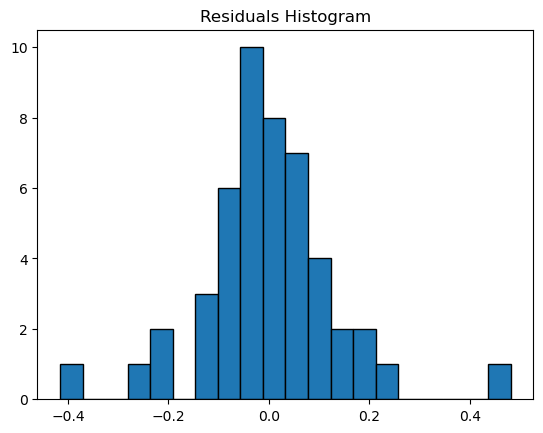

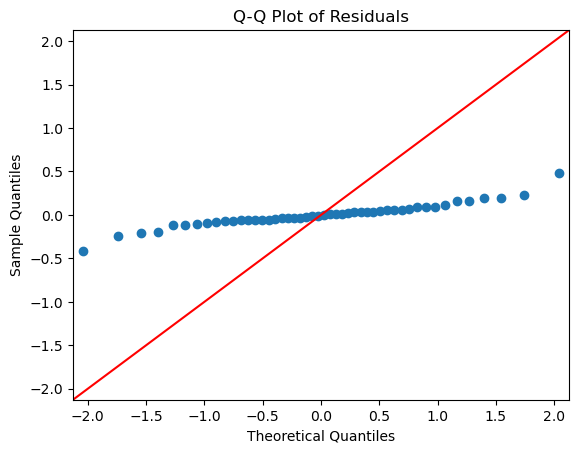

Shapiro-Wilk test p-value: 0.010141752507699553


In [12]:
check_assumptions(E975_alpha_chao1)

In [29]:
V107_alpha_chao1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                   MixedLM       Dependent Variable:       chao1    
No. Observations:        153           Method:                   REML     
No. Groups:              22            Scale:                    0.1523   
Min. group size:         6             Log-Likelihood:           -101.6509
Max. group size:         7             Converged:                Yes      
Mean group size:         7.0                                              
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       4.785    0.164  29.146 0.000  4.464  5.107
group[T.R]                      0.074    0.222   0.332 0.740 -0.362  0.510
C(week_number)[T.1]            -0.751    0.175  -4.300 0.000 -1.093 -0.408
C(week_number)[T.2]            -1.393    0.175  -7.979 0.000 -1.735 -1.051
C(week_number)[T.3]            -1.827    0.175 -10.467 0.000 -2.169 -1.485
C(week_number)[T.4]            -1.904    0.175 -10.909 0.000 -2.246 -1.562
C(week_number)[T.5]            -1.955    0.175 -11.201 0.000 -2.297 -1.613
C(week_number)[T.6]            -2.145    0.175 -12.289 0.000 -2.487 -1.803
group[T.R]:C(week_number)[T.1] -0.009    0.236  -0.036 0.971 -0.472  0.455
group[T.R]:C(week_number)[T.2]  0.214    0.236   0.904 0.366 -0.250  0.677
group[T.R]:C(week_number)[T.3]  0.388    0.236   1.643 0.100 -0.075  0.852
group[T.R]:C(week_number)[T.4]  0.332    0.239   1.388 0.165 -0.137  0.801
group[T.R]:C(week_number)[T.5]  0.289    0.236   1.222 0.222 -0.174  0.752
group[T.R]:C(week_number)[T.6]  0.454    0.236   1.922 0.055 -0.009  0.917
Group Var                       0.117    0.122                            
==========================================================================

"""

### Mann Whitney U

In [14]:
def mann_whitney_test(dataset, test_column: str):

    results_lst = []

    for week, df in dataset.groupby("week"):

        # Getting abundance
        r = df.loc[df["group"]=="R", test_column]
        nr = df.loc[df["group"]=="NR", test_column]

        # Run test
        stat, p = mannwhitneyu(r, nr, alternative="two-sided")
        
        
        # Calculating # Rank-biserial correlation
        rank_biserial = (2 * stat) / (len(r) * len(nr)) - 1
        
        # Calculating normalized - U
        norm_U = stat / (len(r) * len(nr))
        
        # Storing result
        results_lst.append((week, stat, p, rank_biserial, norm_U))
        

    # Create result table and post-hoc test
    result = pd.DataFrame(results_lst, columns=["week","stats","p_value", "rank_biserial", "normalized U"])
    result["q_value"] = multipletests(result["p_value"], method="fdr_bh")[1]
    
    return result

In [15]:
def friedman_test(df, test_column: str):
    
    friedman_result = []
    
    # Formatting table
    test_table = df.pivot_table(
        index = "pt_identifier", 
        columns = "week_number", 
        values = test_column)
    
    # Case handling
    test_table.dropna(inplace = True)
    
    # Running test
    stat, p = friedmanchisquare(*[test_table[col] for col in test_table.columns])
    
    # Storing result
    friedman_result.append((stat, p))

    # Post-hoc test
    friedman_stats_test = pd.DataFrame(friedman_result, columns=["stats","p_value"])
    friedman_stats_test["q_value"] = multipletests(friedman_stats_test["p_value"], method="fdr_bh")[1]
    
    return friedman_stats_test

In [16]:
def posthoc_wlx_test(df, test_column: str):
    
    # Formatting table
    test_table = df.pivot_table(
        index = "pt_identifier", 
        columns = "week_number", 
        values = test_column)
    
    # Case handling
    test_table.dropna(inplace = True)
    
    # Generate pairs
    wk_pairs = list(itertools.combinations(test_table.columns, 2))
    
    # Run test
    test_result = []
    
    for w1, w2 in wk_pairs:
        stat, p = wilcoxon(test_table[w1], test_table[w2])
        test_result.append((w1, w2, stat, p))
        
    # Run FDR calculation
    posthoc_result = pd.DataFrame(test_result, columns=["Week A", "Week B", "stats", "p_value"])
    posthoc_result["q_value"] = multipletests(posthoc_result["p_value"], method="fdr_bh")[1]
        
    return posthoc_result

In [30]:
V107_alpha_test

,sample_id,shannon,simpson,chao1,group,week,pt_identifier,week_number
0,179fece00002a,2.976614,0.095277,4.948760,R,week0,MAID-0018,0
1,179fece00003a,3.665928,0.064398,5.488938,NR,week0,MAID-1101.1,0
2,179fece00004a,3.689434,0.053432,5.379897,R,week0,MAID-0014,0
3,179fece00005a,3.103368,0.073233,4.875197,R,week0,MAID-0024,0
4,179fece00006a,3.761044,0.040539,5.407172,R,week0,MAID-1028,0
...,...,...,...,...,...,...,...,...
148,FF02556045,2.939159,0.094468,4.382027,R,week0,MAID-0560,0
149,FF02556056,3.149177,0.070877,4.418841,R,week0,MAID-0574,0
150,FF02556063,3.313409,0.049602,4.418841,R,week0,MAID-0231,0
151,FF02556074,2.881805,0.097583,4.369448,R,week0,MAID-0553,0


In [18]:
# Run V107 tests
V107_mannwhitney_shn = mann_whitney_test(V107_alpha_test, "shannon")
V107_friedman_shn = friedman_test(V107_alpha_test, "shannon")
V107_posthoc_wlx_shn = posthoc_wlx_test(V107_alpha_test, "shannon")

V107_mannwhitney_spn = mann_whitney_test(V107_alpha_test, "simpson")
V107_friedman_spn = friedman_test(V107_alpha_test, "simpson")
V107_posthoc_wlx_spn = posthoc_wlx_test(V107_alpha_test, "simpson")

V107_mannwhitney_chao1 = mann_whitney_test(V107_alpha_test, "chao1")
V107_friedman_chao1 = friedman_test(V107_alpha_test, "chao1")
V107_posthoc_wlx_chao1 = posthoc_wlx_test(V107_alpha_test, "chao1")

/apps/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [19]:
# Run E975 tests
E975_mannwhitney_shn = mann_whitney_test(E975_alpha_test, "shannon")
E975_friedman_shn = friedman_test(E975_alpha_test, "shannon")
E975_posthoc_wlx_shn = posthoc_wlx_test(E975_alpha_test, "shannon")

E975_mannwhitney_spn = mann_whitney_test(E975_alpha_test, "simpson")
E975_friedman_spn = friedman_test(E975_alpha_test, "simpson")
E975_posthoc_wlx_spn = posthoc_wlx_test(E975_alpha_test, "simpson")

E975_mannwhitney_chao1 = mann_whitney_test(E975_alpha_test, "chao1")
E975_friedman_chao1 = friedman_test(E975_alpha_test, "chao1")
E975_posthoc_wlx_chao1 = posthoc_wlx_test(E975_alpha_test, "chao1")

In [20]:
V107_mannwhitney_shn

,week,stats,p_value,rank_biserial,normalized U,q_value
0,week0,55.0,0.766679,-0.083333,0.458333,0.766679
1,week1,85.0,0.106206,0.416667,0.708333,0.212189
2,week2,84.0,0.121251,0.400000,0.700000,0.212189
3,week3,87.0,0.080575,0.450000,0.725000,0.212189
4,week4,66.0,0.459672,0.200000,0.600000,0.643540
5,week5,69.0,0.575157,0.150000,0.575000,0.671016
6,week6,85.0,0.106206,0.416667,0.708333,0.212189


### Plotting

In [21]:
metrics = ["shannon", "simpson", "chao1"]

# Rehsaping data
V107_alpha_test = V107_alpha_test.reset_index()

V107_melted = V107_alpha_test.melt(
    id_vars = ["sample_id", "group", "week", "week_number", "pt_identifier"], 
    value_vars = metrics,
    var_name = "metric", value_name="value").copy()

In [22]:
E975_alpha_test = E975_alpha_test.reset_index()

E975_melted = E975_alpha_test.melt(
    id_vars=["sample_id", "group", "week", "week_number", "pt_identifier"], 
    value_vars=metrics,
    var_name="metric", value_name="value").copy()

/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

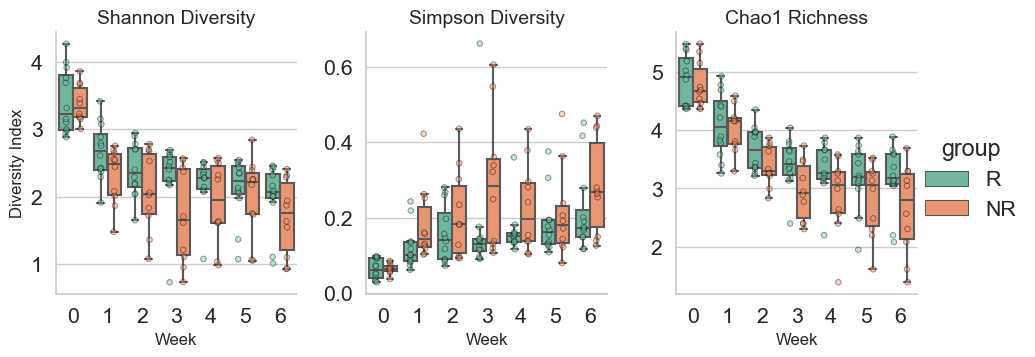

In [23]:
# For V107
metrics = ["shannon", "simpson", "chao1"]

sns.set_theme(style = "whitegrid", font_scale=1.4)

# Custom colour
custom_colour = {"R": "#66c2a5", "NR": "#fc8d62"}

plot = sns.catplot(data = V107_melted,
                x = "week_number",
                y = "value",
                hue = "group",
                col = "metric",
                kind = "box",
                palette = custom_colour,
                sharey = False,
                height = 4,
                aspect = 0.8,
                flierprops = dict(marker='')
                )

for metric, ax in zip(plot.col_names, plot.axes.flat):
    subset = V107_melted[V107_melted["metric"] == metric]
    
    sns.stripplot(
        data=subset,
        x = "week_number",
        y = "value",
        hue = "group",
        dodge = True,
        palette = custom_colour,
        size = 4,
        alpha = 0.4,
        ax = ax,
        jitter = 0.05,
        linewidth = 0.7,
        edgecolor = "black",
        legend = False
    )
    
# Setting title
titles = {
    "shannon": "Shannon Diversity",
    "simpson": "Simpson Diversity",
    "chao1": "Chao1 Richness"
}

for metric, ax in zip(plot.col_names, plot.axes.flat):
    ax.set_title(titles[metric], fontsize = 14) 
    
plot.set_axis_labels("Week", "Diversity Index", fontsize = 12)
plt.savefig("alpha_diversity_V107.png", dpi=300, bbox_inches="tight")

plt.show()

/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/apps/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

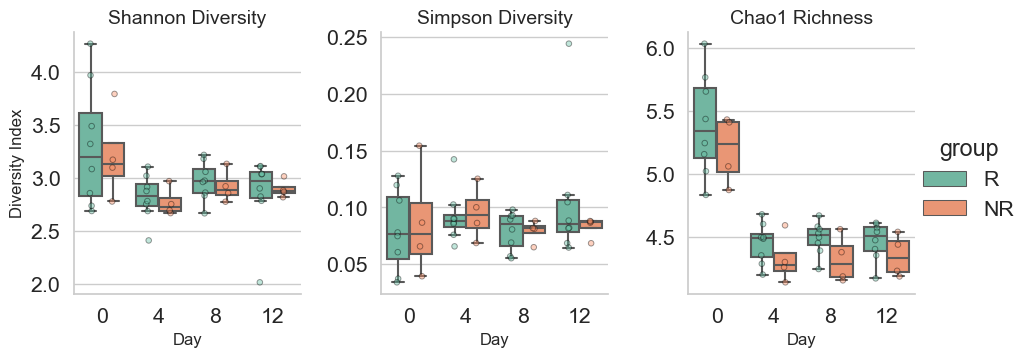

In [24]:
metrics = ["shannon", "simpson", "chao1"]

sns.set_theme(style = "whitegrid", font_scale=1.4)

# Custom colour
custom_colour = {"R": "#66c2a5", "NR": "#fc8d62"}

plot = sns.catplot(data = E975_melted,
                x = "week_number",
                y = "value",
                hue = "group",
                col = "metric",
                kind = "box",
                palette = custom_colour,
                sharey = False,
                height = 4,
                aspect = 0.8,
                flierprops = dict(marker='')
                )

for metric, ax in zip(plot.col_names, plot.axes.flat):
    subset = E975_melted[E975_melted["metric"] == metric]
    
    sns.stripplot(
        data=subset,
        x = "week_number",
        y = "value",
        hue = "group",
        dodge = True,
        palette = custom_colour,
        size = 4,
        alpha = 0.4,
        ax = ax,
        jitter = 0.05,
        linewidth = 0.7,
        edgecolor = "black",
        legend = False
    )
    
# Setting title
titles = {
    "shannon": "Shannon Diversity",
    "simpson": "Simpson Diversity",
    "chao1": "Chao1 Richness"
}

for metric, ax in zip(plot.col_names, plot.axes.flat):
    ax.set_title(titles[metric], fontsize = 14) 
    
plot.set_axis_labels("Day", "Diversity Index", fontsize = 12)
plt.savefig("alpha_diversity_E975.png", dpi=300, bbox_inches="tight")

plt.show()